<h3 align="center"><font color='#1E3F3F' size=6>Diabetes Disease Prediction Model</font></h3>

<hr style="height:1px;border-width:0;color:#1E3F3F;background-color:#1E3F3F">

<h3 align="left"><font color='#B3005E' size=5>Business Problem</font></h3>

<font color='#282A3A' size=3>It is requested to develop a machine learning model that can predict whether individuals are diabetic or not based on their features. Before developing the model, performing the necessary data analysis and feature engineering steps are expected.</font>

<h3 align="left"><font color='#B3005E' size=5>Story of Dataset</font></h3>

<font color='#282A3A' size=3>The dataset is part of a large dataset maintained by the National Institute of Diabetes, Digestive, and Kidney Diseases in the United States. The data was collected for a diabetes study conducted on Pima Indian women aged 21 and over living in Phoenix, the fifth largest city in the state of Arizona in the United States. The target variable is specified as "outcome" and indicates whether the diabetes test result is positive (1) or negative (0).</font>

<h3 align="left"><font color='#B3005E' size=5>Variables</font></h3>

<div align="left">
<img src="images/variables.png" width="600" align="left"/>
</div>

<h3 align="left"><font color='#B3005E' size=5>Imports & Settings</font></h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.simplefilter(action="ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h3 align="left"><font color='#B3005E' size=5>Data Understanding</font></h3>

In [2]:
# Loading data
def load_data():
    dataframe = pd.read_csv('diabetes.csv')
    return dataframe

df = load_data()

In [3]:
# A summary function to know the dataset
def check_df(dataframe, head=5):
    print(' COLUMNS '.center(125, '~'),'\n')
    print(dataframe.columns,'\n')
    print(' HEAD '.center(125, '~'),'\n')
    print(dataframe.head(),'\n')
    print(' TAIL '.center(125, '~'),'\n')
    print(dataframe.tail(),'\n')
    print(' TYPES '.center(125, '~'),'\n')
    print(dataframe.dtypes,'\n')
    print(' INFO '.center(125, '~'),'\n')
    print(dataframe.info(),'\n')
    print(' MISSING VALUES '.center(125, '~'),'\n')
    print(dataframe.isnull().sum(),'\n')
    print(' QUANTILES '.center(125, '~'),'\n')
    print(dataframe.describe([0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]).drop('count').T,'\n')

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ COLUMNS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], dtype='object') 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40      

<h3 align="left"><font color='#B3005E' size=5>Categorical and Numerical Variables</font></h3>

In [4]:
# This function grabs categorical and numerical variables.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    """

    This function provides the names of the categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-appearing categorical variables are also included in the categorical variable list.

    Parameters
    ------
        dataframe: dataframe
            The dataframe of which variable names will be obtained.
        cat_th: int, optional
            Class threshold value for numerical but categorical variables
        car_th: int, optinal
            Class threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
            Categorical variable list
        num_cols: list
            Numerical variable list
        cat_but_car: list
            Categorical-appearing but cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        num_but_cat is included in cat_cols.
        The sum of the returned 3 lists is equal to the total number of variables:
        cat_cols + num_cols + cat_but_car = total number of variables.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


<h3 align="left"><font color='#B3005E' size=5>Categorical Variable Analysis</font></h3>

   Outcome  Ratio
0      500 65.104
1      268 34.896


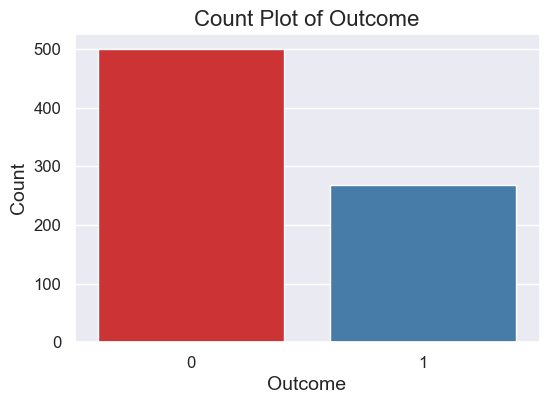

In [5]:
# Information about the categorical variables
def cat_summary(dataframe, col_name, plot=False):
    counts = dataframe[col_name].value_counts()
    ratios = 100 * counts / len(dataframe)
    summary_df = pd.DataFrame({col_name: counts, "Ratio": ratios})
    print(summary_df)
    if plot:
        sns.set(style="darkgrid")

        # Set the figure size and title
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.set_title(f"Count Plot of {col_name}", fontsize=16)

        # Create the count plot
        sns.countplot(x=dataframe[col_name], data=dataframe, ax=ax, palette="Set1")
        ax.set_xlabel(col_name.capitalize(), fontsize=14)
        ax.set_ylabel("Count", fontsize=14)
        ax.tick_params(labelsize=12)


        plt.show(block=True)
    else:
        print(summary_df)
        print("###########################################################")

for col in cat_cols:
    cat_summary(df, col, plot=True)

<h3 align="left"><font color='#B3005E' size=5>Numerical Variable Analysis</font></h3>

Pregnancies Descriptive Statistics

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
25%       1.000
50%       3.000
75%       6.000
90%       9.000
95%      10.000
max      17.000
Name: Pregnancies, dtype: float64


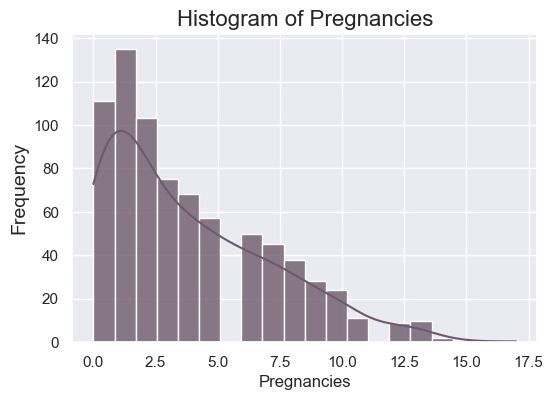

Glucose Descriptive Statistics

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
25%      99.000
50%     117.000
75%     140.250
90%     167.000
95%     181.000
max     199.000
Name: Glucose, dtype: float64


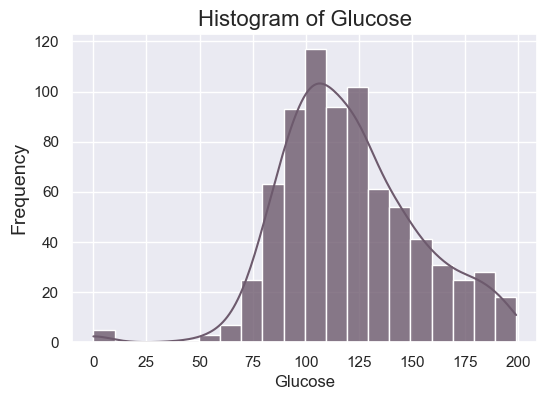

BloodPressure Descriptive Statistics

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
25%      62.000
50%      72.000
75%      80.000
90%      88.000
95%      90.000
max     122.000
Name: BloodPressure, dtype: float64


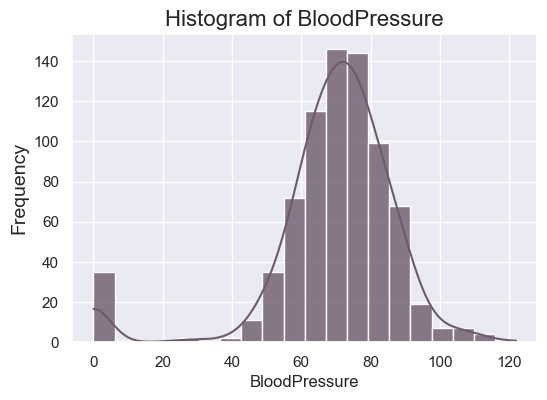

SkinThickness Descriptive Statistics

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
25%       0.000
50%      23.000
75%      32.000
90%      40.000
95%      44.000
max      99.000
Name: SkinThickness, dtype: float64


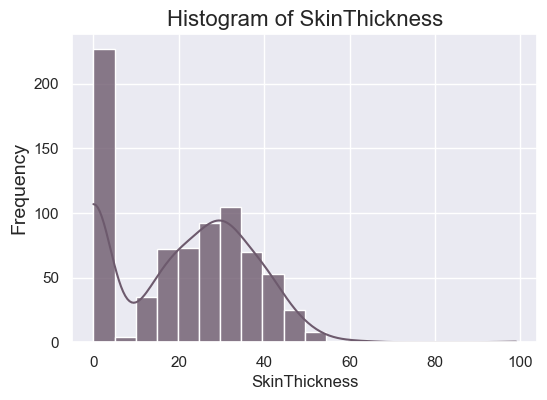

Insulin Descriptive Statistics

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
25%       0.000
50%      30.500
75%     127.250
90%     210.000
95%     293.000
max     846.000
Name: Insulin, dtype: float64


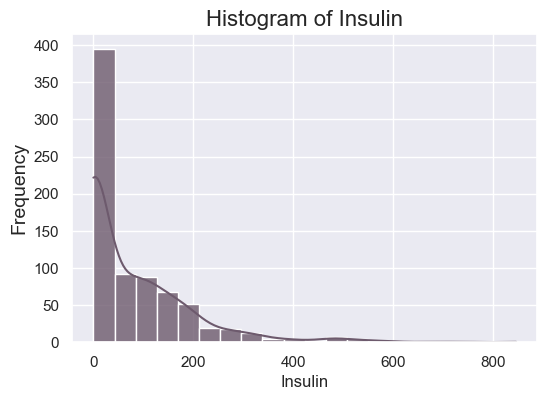

BMI Descriptive Statistics

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
25%      27.300
50%      32.000
75%      36.600
90%      41.500
95%      44.395
max      67.100
Name: BMI, dtype: float64


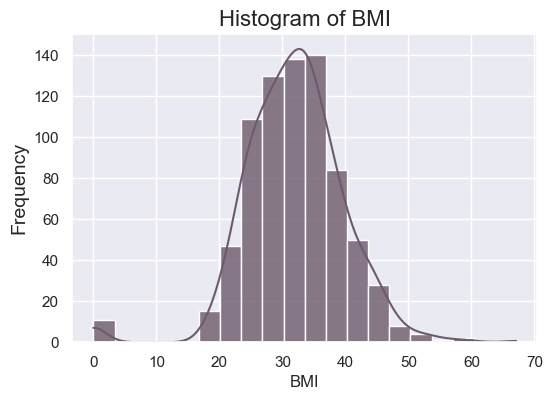

DiabetesPedigreeFunction Descriptive Statistics

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
25%       0.244
50%       0.372
75%       0.626
90%       0.879
95%       1.133
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


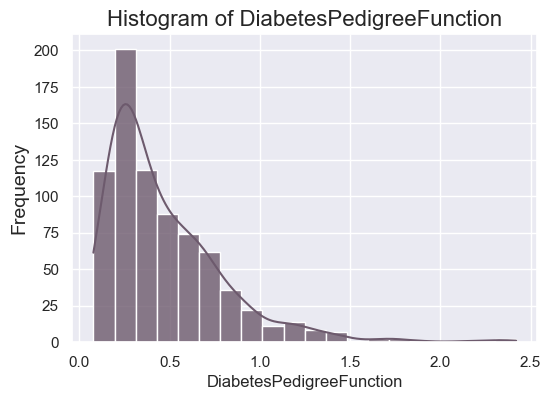

Age Descriptive Statistics

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
25%      24.000
50%      29.000
75%      41.000
90%      51.000
95%      58.000
max      81.000
Name: Age, dtype: float64


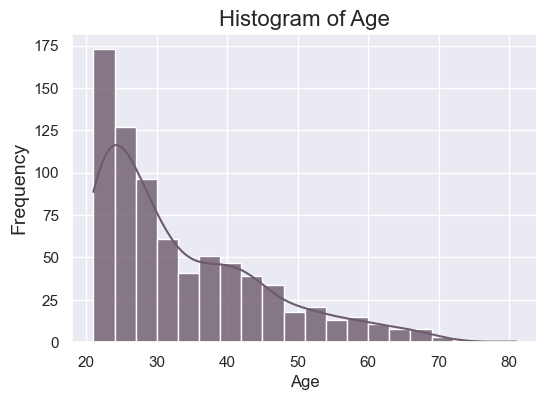

In [6]:
# Information about the numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]
    summary_df = dataframe[numerical_col].describe(quantiles).T
    print(f"\033[1m\033[36m{numerical_col} Descriptive Statistics\n\033[0m")
    print(summary_df)

    if plot:
        plt.figure(figsize=(6, 4))
        sns.set(style="darkgrid")
        sns.histplot(x=dataframe[numerical_col], bins=20, kde=True, color="#6D5A6D", edgecolor="#FFFFFF", alpha=0.8,
                     )
        plt.title(f"Histogram of {numerical_col}", fontsize=16)
        plt.ylabel("Frequency", fontsize=14)
        plt.show(block=True)
   
for col in num_cols:
    num_summary(df, col, plot=True)

<h3 align="left"><font color='#B3005E' size=5>Target Variable Analysis</font></h3>

 Mean of numerical columns grouped by target variable 

         Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
Outcome                                                                                                     
0              3.298  109.980         68.184         19.664   68.792 30.304                     0.430 31.190
1              4.866  141.257         70.825         22.164  100.336 35.143                     0.550 37.067


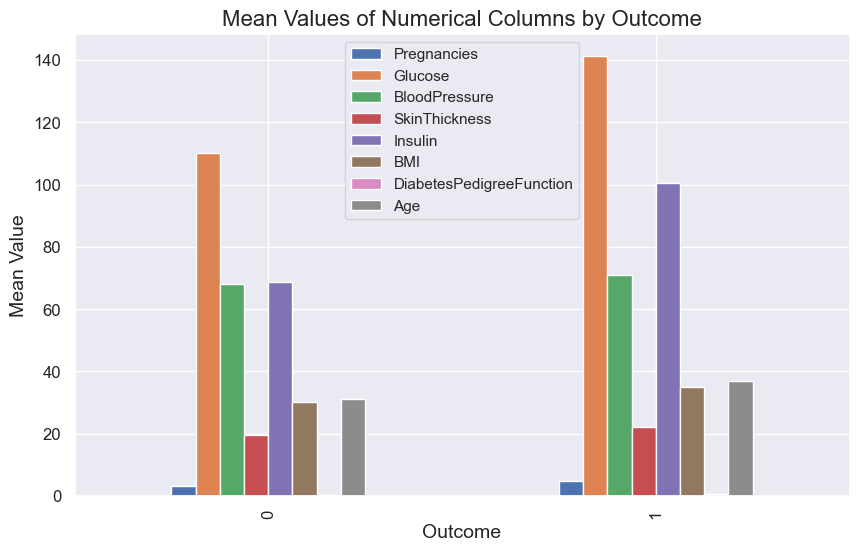

In [7]:
# Target variable is 'Outcome'
def target_summary_with_num(dataframe, target, numerical_col):
    num_means = df.groupby('Outcome').agg({col: 'mean' for col in num_cols})
    print(f"\033[1m\033[36m Mean of numerical columns grouped by target variable \n\033[0m")
    print(num_means)

    # Create bar plot
    ax = num_means.plot(kind='bar', figsize=(10, 6), fontsize=12)
    ax.set_title("Mean Values of Numerical Columns by Outcome", fontsize=16)
    ax.set_xlabel("Outcome", fontsize=14)
    ax.set_ylabel("Mean Value", fontsize=14)
    plt.show()

target_summary_with_num(df, 'Outcome', num_cols)

<h3 align="left"><font color='#B3005E' size=5>Correlation Analysis</font></h3>

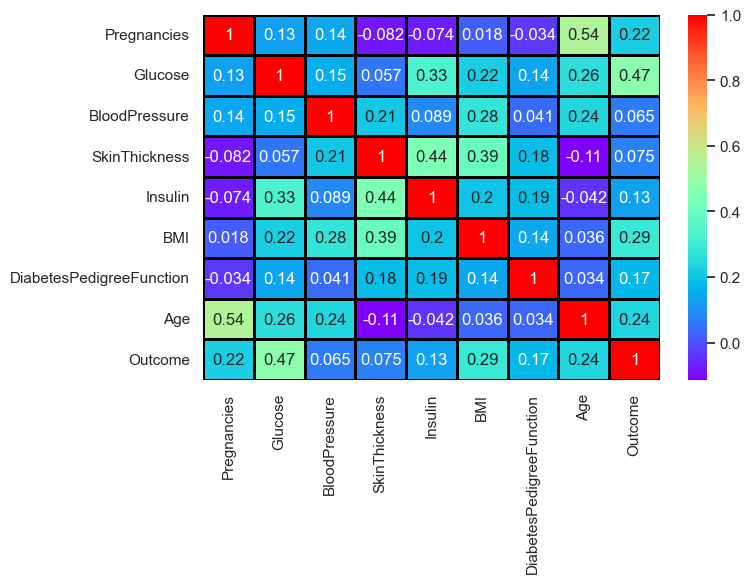

In [8]:
# Let's see if there is correlation between numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, linewidths=2, linecolor='black', cmap='rainbow')
plt.tight_layout()
plt.show()

<font color='#282A3A' size=3>There isn't any high correlation between variables. The highest correlation is between 'Pregnancies' and 'Age' variables with 0.54</font>

<h3 align="left"><font color='#B3005E' size=5>Setting up the base model</font></h3>

<font color='#282A3A' size=3>Let's build a model before performing missing value analysis, outlier analysis and feature engineering and compare the result with the final model.</font>

In [9]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


<h3 align="left"><font color='#B3005E' size=5>Feature Importances</font></h3>

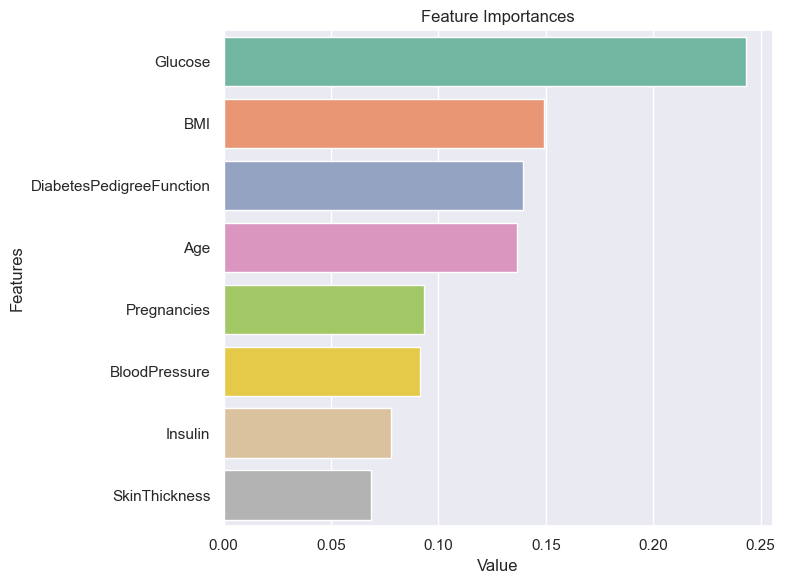

In [10]:
# Most important features for our model
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Features': features.columns})
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num], palette="Set2")
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

<h3 align="left"><font color='#B3005E' size=5>Outlier Analysis</font></h3>

In [11]:
# This function calculates the lower and upper limit thresholds for outlier detection based on the interquartile range (IQR)
# method. Since we have only 768 observations we might want to set the thresholds close to min and max values.
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    print(col, outlier_thresholds(df, col))

Pregnancies (-13.5, 22.5)
Glucose (-38.0, 290.0)
BloodPressure (3.0, 139.0)
SkinThickness (-60.0, 100.0)
Insulin (-315.0, 525.0)
BMI (-3.2499999999999964, 68.35)
DiabetesPedigreeFunction (-0.9054000000000002, 1.9490000000000003)
Age (-21.5, 94.5)


In [12]:
# Let's check if there are outliers in the dataset.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure True
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction True
Age False


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
8              2      197             70             45      543 30.500                     0.158   53        1
13             1      189             60             23      846 30.100                     0.398   59        1
228            4      197             70             39      744 36.700                     2.329   31        0
247            0      165             90             33      680 52.300                     0.427   23        0
286            5      155             84             44      545 38.700                     0.619   34        0
409            1      172             68             49      579 42.400                     0.702   28        1
584            8      124             76             24      600 28.700                     0.687   52        1
655            2      155             52             27      540 38.700                     0.240   25  

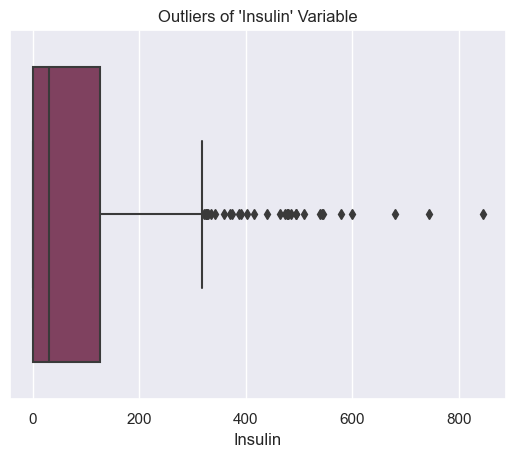

Int64Index([8, 13, 228, 247, 286, 409, 584, 655], dtype='int64')

In [13]:
# Create a function if we want to grab the outliers when its needed.
def grab_outliers(dataframe, col_name, plot=False, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())

    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if plot:
        sns.set(style="darkgrid")
        sns.boxplot(x=col_name, data=dataframe, color='#89375F')
        plt.title(f"Outliers of '{col_name}' Variable")
        plt.show(block=True)

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


# Grab outlier value of 'Insulin' variable.
grab_outliers(df, "Insulin", plot=True, index=True)

In [14]:
df.describe([0.10,0.90, 0.95]).T

,count,mean,std,min,10%,50%,90%,95%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,3.000,9.000,10.000,17.000
Glucose,768.000,120.895,31.973,0.000,85.000,117.000,167.000,181.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,54.000,72.000,88.000,90.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,40.000,44.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,210.000,293.000,846.000
BMI,768.000,31.993,7.884,0.000,23.600,32.000,41.500,44.395,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.165,0.372,0.879,1.133,2.420
Age,768.000,33.241,11.760,21.000,22.000,29.000,51.000,58.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000,1.000


In [15]:
# This function replaces the values in the specified variable that fall below or above the lower and upper outlier thresholds
# with the corresponding threshold values. Removing outliers is an option also but we don't have much observations so this method
# is more effective.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, 'Insulin')
replace_with_thresholds(df, 'BloodPressure')
replace_with_thresholds(df, 'DiabetesPedigreeFunction')

In [16]:
# Let's check if there is any outlier in columns. This method will not completely get rid of outliers, it will reduce the count.
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


<h3 align="left"><font color='#B3005E' size=5>Missing Value Analysis</font></h3>

In [17]:
# Check if there is any missing value
df.isnull().values.any()

False

<font color='#282A3A' size=3>As we see there isn't missing value in our dataset. But there are 0 values in columns that was actually missing values but converted to 0 when this dataset is created. So we have to change those to NaN then continue our process.</font>

In [18]:
df.eq(0).sum() # These are representing 0 values in dataset. 

Pregnancies                 111
Glucose                       5
BloodPressure                 0
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [19]:
# We have also 0 in our target variable that represents people doesnt have the disease. let's exclude it.
# And convert others to NaN
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

df[zero_columns] = df[zero_columns].replace(0, np.nan)

In [20]:
# This function shows the missing value counts of each columns and their ratio. And return columns have missing values.
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_columns = missing_values_table(df, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BMI                11  1.430
Glucose             5  0.650


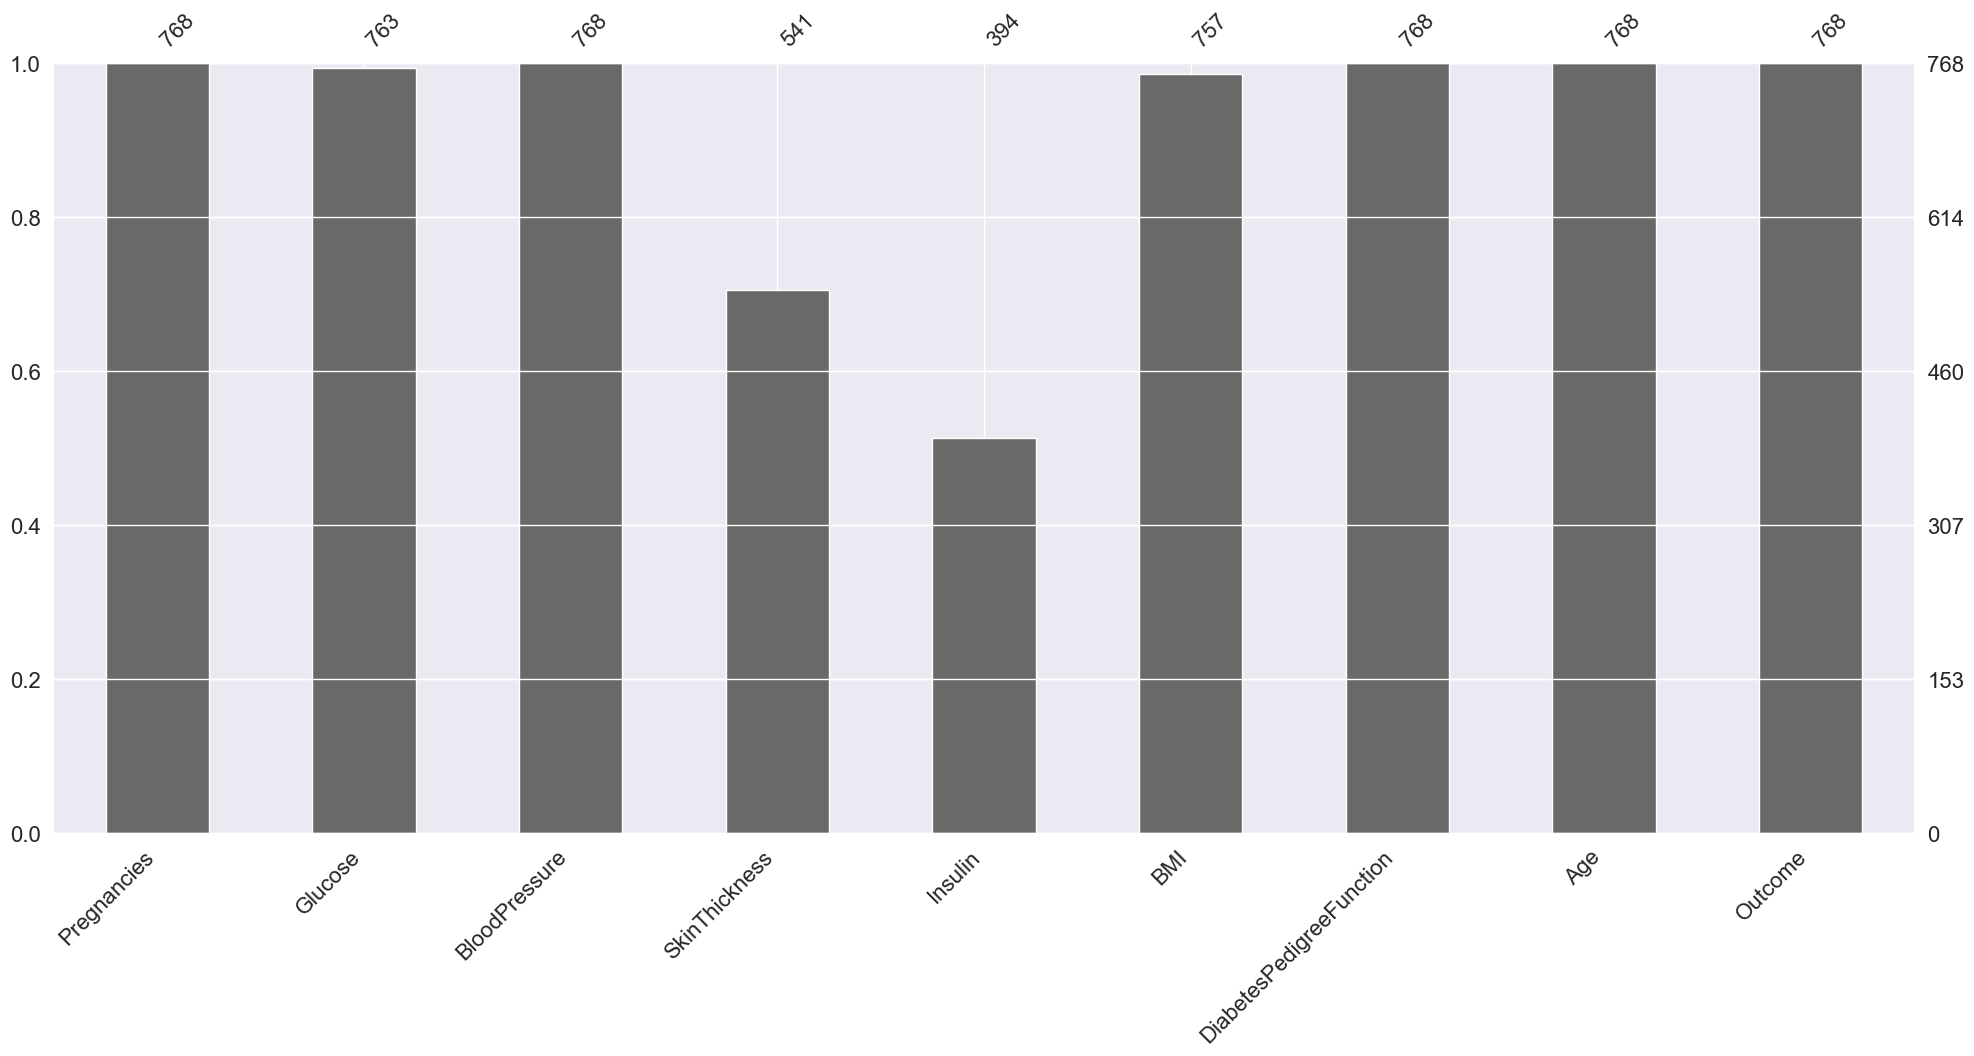

In [21]:
# Not null values in each column
msno.bar(df)
plt.show(block=True)

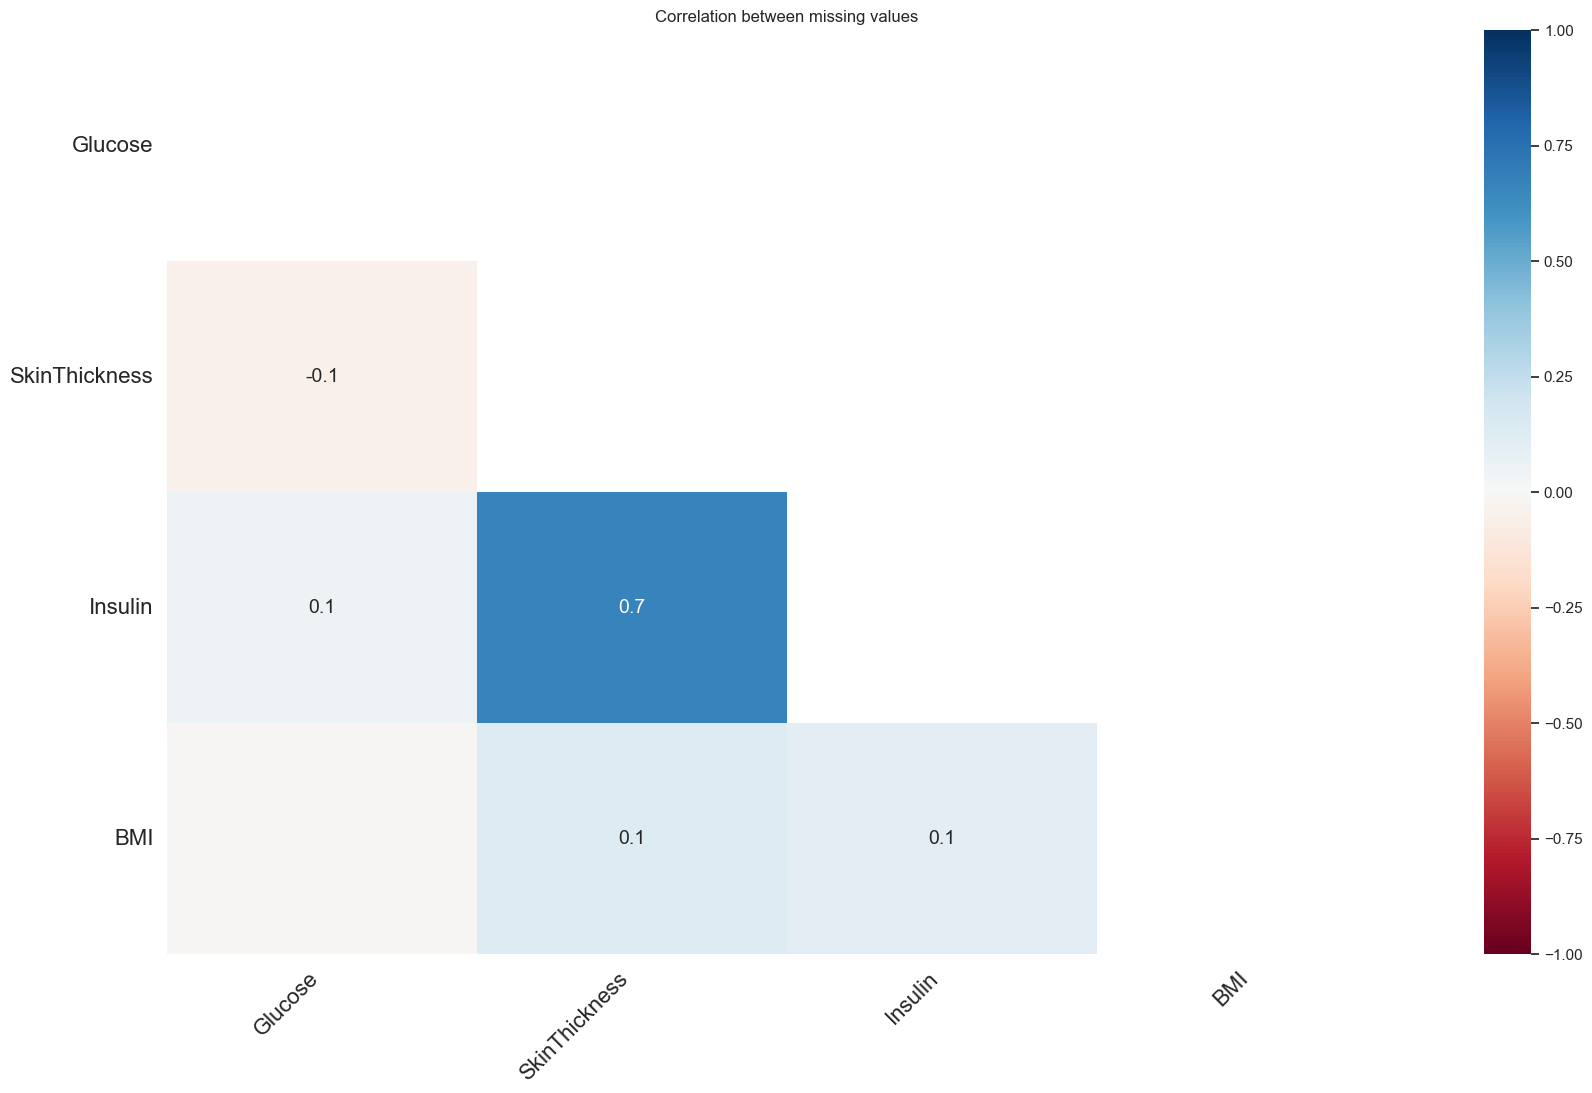

In [22]:
# Correlation between missing values
msno.heatmap(df)
plt.title('Correlation between missing values')
plt.show(block=True)

<h3 align="left"><font color='#B3005E' size=5>Handling with Missing Values</font></h3>

<font color='#282A3A' size=3>There are several methods used for handling missing values; removing, mean imputation, median imputation, mode imputation, prediction and expert knowledge.<br>
Removing can be usable when there are so many observation and removing missing values doesn't affect the performance of the model.<br> Mode imputation is used for categorical variables.<br> Mean imputation can be used when there is not outliers, since we have them we may use median imputation or a machine learning prediction.</font>

In [23]:
# Creating 2 copies of the dataset. We will apply 2 different methods, median and KNNImputer then compare the results.
knn_df = df.copy()
median_df = df.copy()

In [24]:
# Using a lambda function to fill null values with median value of non Object variables.
median_df = median_df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

In [25]:
median_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [26]:
knn_df = pd.get_dummies(knn_df[num_cols], drop_first=True)

# Standardization of Variables
scaler = MinMaxScaler()
knn_df = pd.DataFrame(scaler.fit_transform(knn_df), columns=knn_df.columns)
knn_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.353,0.671,0.580,0.304,NaN,0.315,0.293,0.483
1,0.059,0.265,0.529,0.239,NaN,0.172,0.146,0.167
2,0.471,0.897,0.513,NaN,NaN,0.104,0.317,0.183
3,0.059,0.290,0.529,0.174,0.157,0.202,0.048,0.000
4,0.000,0.600,0.311,0.304,0.301,0.509,1.000,0.200


In [27]:
# Applying KNN
imputer = KNNImputer(n_neighbors=5)
knn_df = pd.DataFrame(imputer.fit_transform(knn_df), columns=knn_df.columns)
knn_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.353,0.671,0.580,0.304,0.468,0.315,0.293,0.483
1,0.059,0.265,0.529,0.239,0.096,0.172,0.146,0.167
2,0.471,0.897,0.513,0.274,0.448,0.104,0.317,0.183
3,0.059,0.290,0.529,0.174,0.157,0.202,0.048,0.000
4,0.000,0.600,0.311,0.304,0.301,0.509,1.000,0.200


In [28]:
knn_df = pd.DataFrame(scaler.inverse_transform(knn_df), columns=knn_df.columns)

In [29]:
knn_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [30]:
# Now check on a variable. This shows what the missing values are filled with in both method
df["insulin_knn"] = knn_df[["Insulin"]]
df["insulin_median"] = median_df[["Insulin"]]
df.loc[df["Insulin"].isnull(), ["Insulin", "insulin_knn", "insulin_median"]].sort_values(by='insulin_knn').head(10)

,Insulin,insulin_knn,insulin_median
62,NaN,48.600,125.000
149,NaN,53.000,125.000
438,NaN,53.600,125.000
461,NaN,54.400,125.000
55,NaN,55.200,125.000
183,NaN,55.200,125.000
210,NaN,55.600,125.000
398,NaN,56.600,125.000
74,NaN,56.800,125.000
488,NaN,58.400,125.000


In [31]:
knn_df['Insulin'].mean()

151.9028645833333

In [32]:
df['Insulin'].mean()

153.3223350253807

In [33]:
df["Insulin"].describe().T

count   394.000
mean    153.322
std     109.473
min      14.000
25%      76.250
50%     125.000
75%     190.000
max     525.000
Name: Insulin, dtype: float64

In [34]:
# Replace the null values with median in out main data. 
df = df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

# Drop the insulin_knn and insulin_median. 
df.drop(['insulin_knn', 'insulin_median'], axis=1, inplace=True)

In [35]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<h3 align="left"><font color='#B3005E' size=5>Feature Extraction</font></h3>

In [36]:
# Categorizes individuals into "mature" or "senior" based on their age.
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

# Categorizes individuals into "Underweight", "Healthy", "Overweight", or "Obese" based on their BMI.
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

# Categorizes individuals into "Normal", "Prediabetes", or "Diabetes" based on their glucose levels.
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# Combines the "Age" and "BMI" features to create new categorical labels based on both age and BMI.
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"
df["NEW_AGE_BMI_NOM"]

# Combines the "Age" and "Glucose" features to create new categorical labels based on both age and glucose levels.
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


# Classifies individuals as having "Normal" or "Abnormal" insulin levels based on a range of values.
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

# Multiplies the "Glucose" and "Insulin" features to create a new feature
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

# Multiplies the "Glucose" and "Pregnancies" features to create a new feature.
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [37]:
# Uppercase column names
df.columns = [col.upper() for col in df.columns]

In [38]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40,35.000,168.000,43.100,1.949,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


<h3 align="left"><font color='#B3005E' size=5>Label Encoding</font></h3>

In [39]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [40]:
# Label encoding
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [41]:
# Object variables that has 2 unique value
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [42]:
for col in binary_cols:
    df = label_encoder(df, col)

In [43]:
# One-Hot Encoding
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [44]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [45]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [46]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40,35.000,168.000,43.100,1.949,33,1,0,0,23016.000,0.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [47]:
# Standardization
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,0.146,0.671,-0.183,0.167,0.487,1.426,1,1,1,0.034,0.882,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.172,-0.012,-0.183,-0.852,-0.370,-0.191,0,0,1,-0.520,-0.858,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.278,-0.012,-0.183,-1.333,0.627,-0.106,1,0,1,0.343,2.129,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.172,-0.695,-0.572,-0.634,-0.941,-1.042,0,0,1,-0.680,-0.849,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-1.551,0.671,0.358,1.549,4.593,-0.020,1,0,0,0.353,-1.042,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [48]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.8
Recall: 0.736
Precision: 0.65
F1: 0.69
Auc: 0.78


<font color='#282A3A' size=5>Now as we see the model has an accuracy of 0.80 which means it correctly predicts the outcome with 80% accuracy on the test data.</font>

    Value                            Feature
1   0.135                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
11  0.099            NEW_GLUCOSE*PREGNANCIES
5   0.099                                BMI
7   0.098                                AGE
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


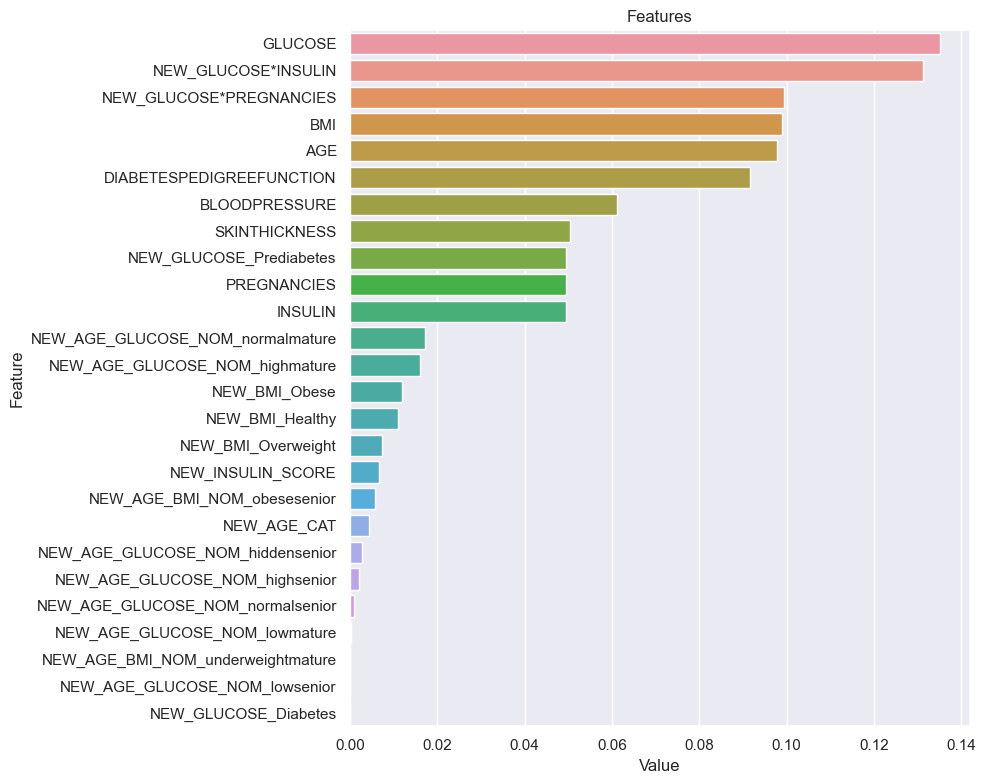

In [49]:
# What are the most effective features.
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

<h3 align="left"><font color='#B3005E' size=5>Some Visualization of Important Features</font></h3>

In [137]:
df[num_cols] = scaler.inverse_transform(df[num_cols])
df[num_cols] = df[num_cols].astype(int)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,NEW_AGE
0,24,4623,1427,336,10087,259,0,620,1,1,1,262566381,410432,1,0,0,0,1,0,0,0,0,0,0,1,1,0,Mature
1,7,2707,1313,283,10087,211,0,397,0,0,1,150805926,39721,0,0,0,0,0,0,0,1,0,0,1,0,0,0,Mature
2,30,5688,1276,283,10087,190,0,409,1,0,1,324655523,676347,0,0,0,1,0,0,0,0,0,1,0,0,1,0,Mature
3,7,2828,1313,231,7620,224,0,280,0,0,1,118746641,41568,0,0,0,0,0,0,0,1,0,0,1,0,0,0,Young
4,3,4288,823,336,13509,327,0,421,1,0,0,326656568,480,0,0,0,1,0,0,0,0,0,0,0,1,0,0,Mature


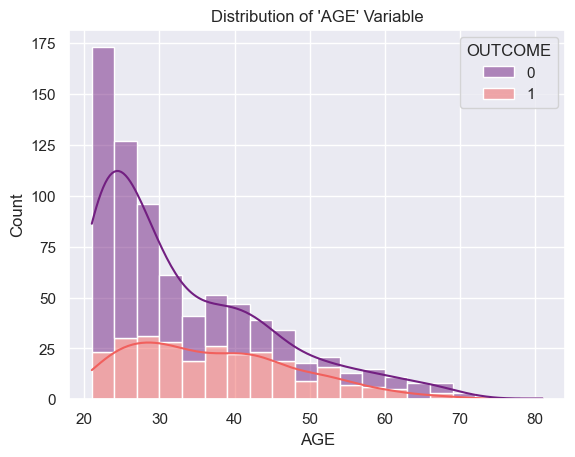

In [85]:
sns.histplot(data=df, x='AGE', kde=True, hue='OUTCOME', bins=20, palette='magma', multiple='stack')
plt.title("Distribution of 'AGE' Variable")
plt.show()

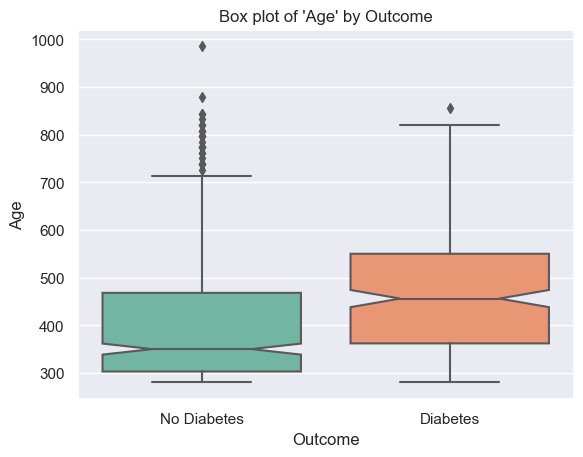

In [141]:
sns.boxplot(data=df, x='OUTCOME', y='AGE', palette='Set2', notch=True)
plt.title("Box plot of 'Age' by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Age")
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.show()

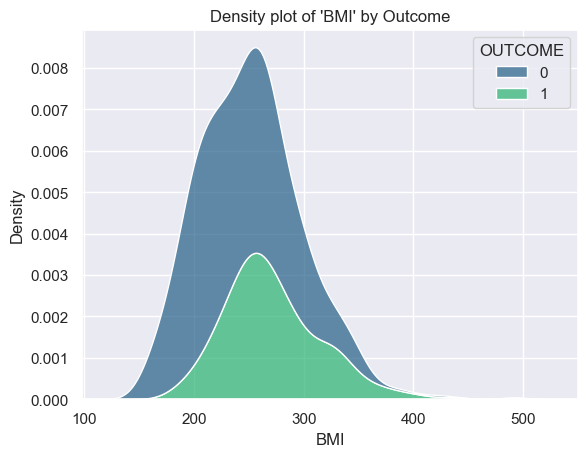

In [144]:
sns.kdeplot(data=df, x='BMI', hue='OUTCOME', multiple='stack', palette='viridis', fill=True)
plt.title("Density plot of 'BMI' by Outcome")
plt.xlabel("BMI")
plt.ylabel("Density")
plt.show()

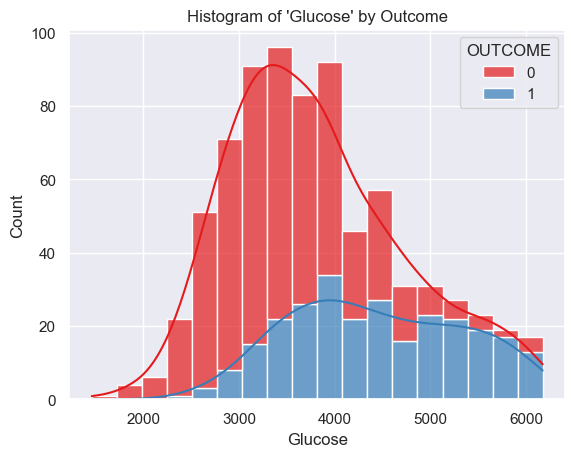

In [142]:
# Histogram of 'Glucose' by Outcome
sns.histplot(data=df, x='GLUCOSE', hue='OUTCOME', multiple='stack', kde=True, palette='Set1', alpha=0.7)
plt.title("Histogram of 'Glucose' by Outcome")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.show()

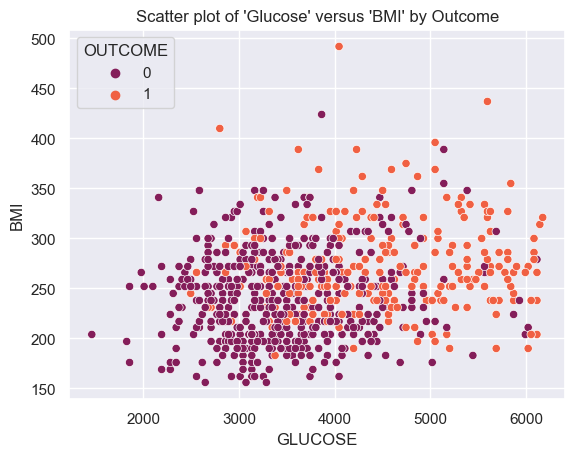

In [145]:
# Relation Between 'BMI' and 'GLUCOSE' Variables
sns.scatterplot(data=df, x='GLUCOSE', y='BMI', hue='OUTCOME', palette='rocket')
plt.title("Scatter plot of 'Glucose' versus 'BMI' by Outcome")
plt.show()

<h3 align="left"><font color='#B3005E' size=5>Resources</font></h3>

<font size=5>https://numpy.org/<br><br>
https://seaborn.pydata.org/<br><br>
https://pandas.pydata.org<br><br>
https://scikit-learn.org/</font>